<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week5/RNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clothing Reviews Sentiment Analysis with RNN
# TensorFlow Implementation

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Download stopwords if needed
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Step 1: Data Loading and Preprocessing
print("Loading and preprocessing data...")

# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text
    return ""


Loading and preprocessing data...


In [ ]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
data = pd.read_csv(url)
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
# Clean the review text
data['clean_review'] = data['Review Text'].apply(clean_text)


In [ ]:
# Convert Rating to binary sentiment (1-3: Negative, 4-5: Positive)
data['sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 4 else 0)


In [ ]:
# Check class distribution
print("Class distribution:")
print(data['sentiment'].value_counts())


Class distribution:
sentiment
1    18208
0     5278
Name: count, dtype: int64


In [ ]:
# Tokenize the text
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<UNK>')
tokenizer.fit_on_texts(data['clean_review'])


In [ ]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['clean_review'])
max_len = 100  # Maximum length of reviews
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:
# Vocabulary size
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 10000


In [ ]:
# Split the data
X = padded_sequences
y = data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 18788
Testing set size: 4698


In [ ]:
# Step 2: Build the RNN Model
# Define the model architecture
def create_model(vocab_size, embed_dim, lstm_units, dropout_rate=0.5):
    """
    Create a bidirectional LSTM model for sentiment analysis

    Parameters:
    - vocab_size: size of the vocabulary
    - embed_dim: dimension of word embeddings
    - lstm_units: number of LSTM units
    - dropout_rate: dropout rate for regularization

    Returns:
    - model: compiled Keras model
    """
    model = Sequential()

    # Embedding layer
    # The embedding layer maps vocabulary indices to dense vectors of fixed size
    # embed_dim is the dimension of these vectors
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embed_dim,
                        input_length=max_len))

    # Bidirectional LSTM layer
    # This processes the sequence in both forward and backward directions
    # lstm_units is the number of units in the LSTM cell
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))

    # Dropout for regularization to prevent overfitting
    # dropout_rate is the fraction of input units to drop
    model.add(Dropout(dropout_rate))

    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(lstm_units)))

    # Dropout after LSTM
    model.add(Dropout(dropout_rate))

    # Dense layer with sigmoid activation for binary classification
    # The sigmoid function maps any input to a value between 0 and 1
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    # Binary cross-entropy loss is used for binary classification problems
    # Adam optimizer adapts the learning rate for each parameter
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [ ]:
# Create and compile the model
embed_dim = 256  # Embedding dimension
lstm_units = 128  # Number of LSTM units

model = create_model(vocab_size, embed_dim, lstm_units)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 3: Define callbacks for training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    # Model checkpoint to save the best model
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
]


In [ ]:
# Step 4: Train the model
print("Training the model...")
batch_size = 64
epochs = 15  # Start with this, increase if needed
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of training data for validation
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Training the model...
Epoch 1/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9078 - loss: 0.2369 - val_accuracy: 0.8866 - val_loss: 0.2957
Epoch 2/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9340 - loss: 0.1729 - val_accuracy: 0.8776 - val_loss: 0.3340
Epoch 3/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9516 - loss: 0.1398 - val_accuracy: 0.8787 - val_loss: 0.3469
Epoch 4/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9616 - loss: 0.1147 - val_accuracy: 0.8707 - val_loss: 0.4466


In [ ]:
# Step 5: Evaluate the model
# Functions for calculating and displaying evaluation metrics
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """
    Calculate various evaluation metrics

    Parameters:
    - y_true: true labels
    - y_pred_proba: predicted probabilities
    - threshold: threshold for binary classification

    Returns:
    - dict: dictionary containing various metrics
    """
    y_pred = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Calculate AUC only if there are both positive and negative samples
    if len(set(y_true)) > 1:
        auc = roc_auc_score(y_true, y_pred_proba)
    else:
        auc = float('nan')

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }

In [ ]:
def display_metrics(metrics, dataset_name=""):
    """Display metrics in a formatted way"""
    print(f"\n--- {dataset_name} Metrics ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")


In [ ]:
# Evaluate on training set
y_train_pred = model.predict(X_train)
train_metrics = calculate_metrics(y_train, y_train_pred)
display_metrics(train_metrics, "Training")


588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

--- Training Metrics ---
Accuracy: 0.9349
Precision: 0.9483
Recall: 0.9688
F1 Score: 0.9584
AUC: 0.9705


In [ ]:
# Evaluate on test set
y_test_pred = model.predict(X_test)
test_metrics = calculate_metrics(y_test, y_test_pred)
display_metrics(test_metrics, "Testing")


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

--- Testing Metrics ---
Accuracy: 0.8697
Precision: 0.8954
Recall: 0.9421
F1 Score: 0.9181
AUC: 0.9035


In [ ]:
# If test accuracy is below 85%, try to improve the model
if test_metrics['accuracy'] < 0.85:
    print("Test accuracy below 85%. Adjusting model architecture and retraining...")

    # Create an improved model with more capacity
    embed_dim = 300  # Increased embedding dimension
    lstm_units = 256  # Increased LSTM units

    # Define a more complex model
    improved_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(lstm_units // 2, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(lstm_units // 4)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    improved_model.compile(loss='binary_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                          metrics=['accuracy'])

    # Train the improved model
    improved_history = improved_model.fit(
        X_train, y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=20,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ModelCheckpoint('best_improved_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
        ]
    )

    # Re-evaluate with improved model
    y_test_pred_improved = improved_model.predict(X_test)
    test_metrics_improved = calculate_metrics(y_test, y_test_pred_improved)
    display_metrics(test_metrics_improved, "Testing (Improved Model)")

    # Use the better model for future steps
    if test_metrics_improved['accuracy'] > test_metrics['accuracy']:
        model = improved_model
        history = improved_history
        y_test_pred = y_test_pred_improved
        test_metrics = test_metrics_improved


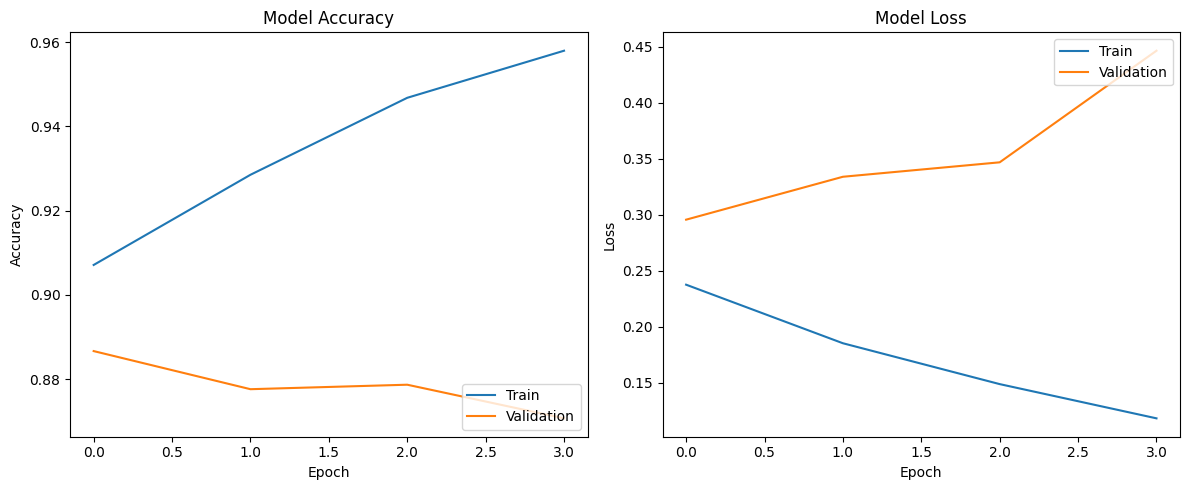

In [ ]:
# Step 6: Visualize Results
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

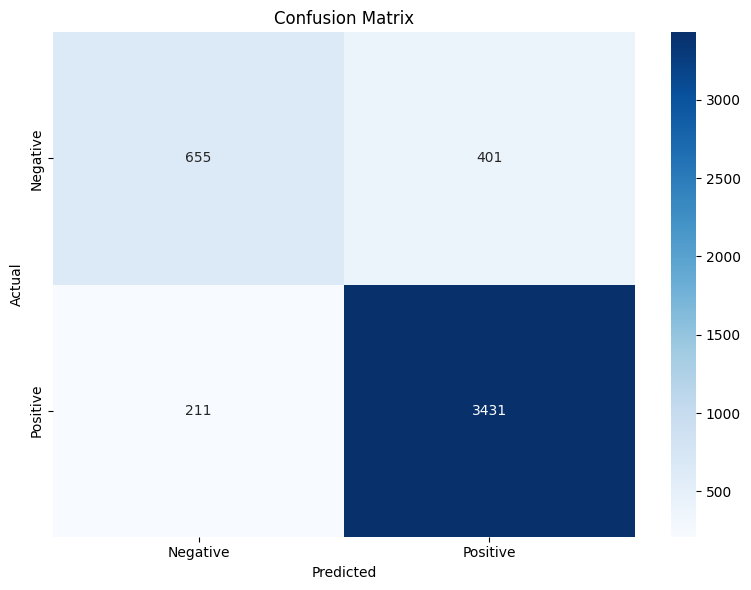

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


In [ ]:
# Step 7: Save the model and tokenizer
model.save('sentiment_analysis_rnn.h5')
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Model and tokenizer saved.")


Model and tokenizer saved.


In [ ]:
# Step 8: Function for making predictions on new data
def predict_sentiment(text, tokenizer, model, max_len=100):
    """
    Predict sentiment for a given text

    Parameters:
    - text: input text string
    - tokenizer: fitted tokenizer
    - model: trained model
    - max_len: maximum sequence length

    Returns:
    - prediction: sentiment prediction ("Positive" or "Negative")
    - confidence: prediction confidence
    """
    # Clean and preprocess the text
    cleaned_text = clean_text(text)
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    # Make prediction
    prediction_prob = model.predict(padded_sequence)[0][0]
    # Determine sentiment and confidence
    sentiment = "Positive" if prediction_prob >= 0.5 else "Negative"
    confidence = prediction_prob if prediction_prob >= 0.5 else 1 - prediction_prob

    return sentiment, confidence


In [ ]:
# Example usage
example_review = "I absolutely love this dress! It fits perfectly and looks amazing."
prediction, confidence = predict_sentiment(example_review, tokenizer, model)
print(f"Example Review: '{example_review}'")
print(f"Prediction: {prediction} with {confidence:.4f} confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Example Review: 'I absolutely love this dress! It fits perfectly and looks amazing.'
Prediction: Positive with 0.9942 confidence


# Summary of Mathematical Equations Used in the Model

## 1. Embedding Layer
- Transforms word indices into dense vectors of fixed size.
- If $E$ is the embedding matrix, and $x$ is a word index, then the embedding is $E[x]$.

## 2. LSTM Cell (Long Short-Term Memory)
- **Forget Gate**: $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$
  - The forget gate determines what information to discard from the cell state.
  - $\sigma$ is the sigmoid function that outputs values between 0 and 1.
- **Input Gate**: $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
  - The input gate determines what new information to store in the cell state.
- **Cell State Candidate**: $\tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)$
  - This creates new candidate values that could be added to the cell state.
- **Update Cell State**: $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$
  - The new cell state combines the old state weighted by the forget gate and the new candidate values weighted by the input gate.
- **Output Gate**: $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
  - The output gate determines what information from the cell state to output.
- **Hidden State**: $h_t = o_t * \tanh(C_t)$
  - The hidden state contains filtered information from the cell state.

## 3. Bidirectional LSTM
- Processes the input sequence in both directions (forward and backward)
- Final output is the concatenation of both directions
- Forward LSTM: $h_t = \text{LSTM}_{\text{forward}}(x_t, h_{t-1})$
- Backward LSTM: $h'_t = \text{LSTM}_{\text{backward}}(x_t, h'_{t+1})$
- Output: $\text{output}_t = [h_t, h'_t]$
- This helps capture dependencies in both directions

## 4. Dropout
- During training, randomly sets a fraction $p$ of the input units to 0
- Formula: $y = d * x$ where $d$ is a binary mask sampled from $\text{Bernoulli}(1-p)$
- This prevents overfitting by making the network more robust

## 5. Dense Layer
- Linear transformation: $y = Wx + b$
- $W$ is the weight matrix, $b$ is the bias term

## 6. Sigmoid Activation
- $\sigma(x) = \frac{1}{1 + e^{-x}}$
- Maps input to a value between 0 and 1, making it suitable for binary classification

## 7. Binary Cross Entropy Loss
- $\text{BCE}(y, \hat{y}) = -(y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}))$
- Measures the dissimilarity between the true labels $y$ and predicted probabilities $\hat{y}$

## 8. Adam Optimizer
- Adaptive learning rate optimization algorithm that computes individual learning rates for different parameters
- First moment estimate (momentum): $m_t = \beta_1 * m_{t-1} + (1 - \beta_1) * g_t$
- Second moment estimate (velocity): $v_t = \beta_2 * v_{t-1} + (1 - \beta_2) * g_t^2$
- Bias correction: $\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$
- Parameter update: $\theta_t = \theta_{t-1} - \alpha * \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$
- Where $g_t$ is the gradient, $\alpha$ is the learning rate, and $\beta_1$, $\beta_2$, $\epsilon$ are hyperparameters

## 9. Evaluation Metrics
- Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
- Precision = $\frac{TP}{TP + FP}$
- Recall = $\frac{TP}{TP + FN}$
- F1 Score = $2 * \frac{Precision * Recall}{Precision + Recall}$
- AUC: Area under the ROC curve, measuring the model's ability to distinguish between classes

Where:
- TP = True Positives (correctly predicted positive examples)
- TN = True Negatives (correctly predicted negative examples)
- FP = False Positives (negative examples predicted as positive)
- FN = False Negatives (positive examples predicted as negative)